In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from core.data.utils import read_all_datasets, read_all_metadata
from core.data.processing.normalization import robust_zscore_normalization_per_dataset

In [2]:
DATA_DIR = '../../db'

dataset, dataset_label = read_all_datasets(DATA_DIR, dropna=False)
metadata = read_all_metadata(DATA_DIR)

In [3]:
y = metadata[metadata.disease.isin(['Ctrl', 'UC']) & metadata.time_of_biopsy.isin([None, 'W0', 'Before'])].disease
dataset_labels = dataset_label.loc[y.index]
X = dataset.loc[y.index]
X = X.dropna(axis=1)

X.shape, y.shape

((934, 14279), (934,))

In [4]:
X_norm = robust_zscore_normalization_per_dataset(X, dataset_label)

In [5]:
from core.utils.genes import entrez_id_to_gene_symbol

X_norm = entrez_id_to_gene_symbol(X_norm)

20 input query terms found no hit:	['10638', '129790', '157247', '158295', '158696', '23285', '26148', '283174', '283588', '284083', '2


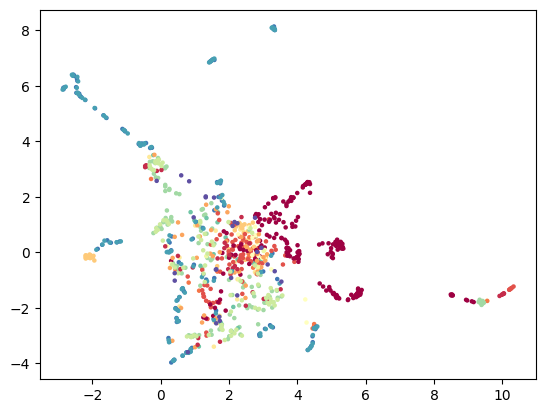

In [15]:
import umap
import pandas as pd
import matplotlib.pyplot as plt

umap_embedding = umap.UMAP().fit_transform(X_norm)

plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=pd.Categorical(dataset_labels).codes, cmap='Spectral', s=5)
plt.show()

In [6]:
from core.stats.tests import test_two_groups


test_data = X_norm.astype(float)
test_data['disease'] = y

test_results = test_two_groups(test_data, 'disease', alpha=0.05/test_data.shape[1])

Test results for disease:
Group counts: 235 | 699
- BACE2: [Mann-Whitney U test] p-value = 0.0; mean difference = 0.9087
- CCL11: [Mann-Whitney U test] p-value = 0.0; mean difference = 0.7703
- GPX8: [Mann-Whitney U test] p-value = 0.0; mean difference = 0.8996
- DAPP1: [Mann-Whitney U test] p-value = 0.0; mean difference = 0.8065
- SAMD9L: [Mann-Whitney U test] p-value = 0.0; mean difference = 0.7356
- PDZK1IP1: [Mann-Whitney U test] p-value = 0.0; mean difference = 0.8228
- IL1B: [Mann-Whitney U test] p-value = 0.0; mean difference = 0.8137
- COL1A2: [Mann-Whitney U test] p-value = 0.0; mean difference = 0.7676
- SLC39A5: [Mann-Whitney U test] p-value = 0.0; mean difference = -0.7068
- C4BPB: [Mann-Whitney U test] p-value = 0.0; mean difference = 0.7185
- DUOX2: [Mann-Whitney U test] p-value = 0.0; mean difference = 1.1104
- UBE2L6: [Mann-Whitney U test] p-value = 0.0; mean difference = 0.8407
- TGFBI: [Mann-Whitney U test] p-value = 0.0; mean difference = 0.784
- CENPV: [Mann-Whitne

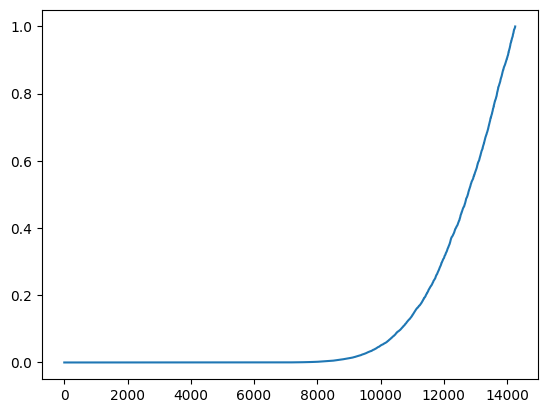

In [7]:
import matplotlib.pyplot as plt

plt.plot([p for f, (p, d, t) in test_results]);

In [8]:
genes = [f for f, (p, d, t) in test_results if p < 0.05/test_data.shape[1]]

In [9]:
import gseapy as gp

# libraries = gp.get_library_name(organism='Human')
# print(libraries)

gene_list = genes[:500]
enrichr_libraries = ['WikiPathway_2023_Human']

enrichr_results = gp.enrichr(gene_list=gene_list, gene_sets=enrichr_libraries, organism='Human', outdir='../../results/enrichr_kegg', cutoff=0.05)

/usr/local/anaconda3/envs/ibd/lib/python3.11/site-packages/gseapy/plot.py:689: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(


In [19]:
enrichr_results.res2d[enrichr_results.res2d['Adjusted P-value'] < 0.05].sort_values('Combined Score', ascending=False).head(10)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
23,WikiPathway_2023_Human,Arachidonic Acid AA ARA Oxylipin Metabolism WP...,3/4,6.097384e-05,1.316019e-03,0,0,117.700201,1142.288171,EPHX2;TBXAS1;PTGS2
0,WikiPathway_2023_Human,Mitochondrial Fatty Acid Oxidation Disorders W...,9/19,2.625820e-10,1.360175e-07,0,0,35.725051,788.110979,HADHA;CPT1A;SLC22A5;CPT2;ECI1;ACADM;SLC25A20;H...
1,WikiPathway_2023_Human,Mitochondrial Long Chain Fatty Acid Beta Oxida...,8/17,2.877527e-09,6.199696e-07,0,0,35.214092,692.532115,HADHA;CPT1A;CPT2;ECI1;ACADM;SLC25A20;HADH;ACSF2
3,WikiPathway_2023_Human,miRNA Targets In ECM And Membrane Receptors WP...,8/22,3.389924e-08,4.389951e-06,0,0,22.631823,389.264497,COL3A1;COL1A2;COL4A1;LAMA4;COL6A1;COL5A2;COL6A...
2,WikiPathway_2023_Human,Burn Wound Healing WP5055,14/74,3.590558e-09,6.199696e-07,0,0,9.333333,181.486278,CXCL8;MMP1;TNC;CXCL1;INHBA;ICAM1;COL1A1;COL1A2...
22,WikiPathway_2023_Human,Platelet Mediated Interactions With Vascular A...,5/17,4.617826e-05,1.040015e-03,0,0,16.404040,163.761560,SELP;CD40;IL1B;ICAM1;PF4
8,WikiPathway_2023_Human,Fatty Acid Beta Oxidation WP143,8/34,1.478045e-06,8.506973e-05,0,0,12.178862,163.498662,HADHA;CPT1A;CPT2;ECI1;ACSL5;ACADM;SLC25A20;HADH
10,WikiPathway_2023_Human,Photodynamic Therapy Induced NF kB Survival Si...,8/35,1.874348e-06,8.826475e-05,0,0,11.727191,154.649390,CXCL8;BCL2A1;MMP1;IL1B;MMP3;PTGS2;CXCL2;ICAM1
14,WikiPathway_2023_Human,Matrix Metalloproteinases WP129,7/30,7.232791e-06,2.497724e-04,0,0,12.023900,142.325527,MMP12;MMP7;MMP1;MMP3;MMP19;TIMP1;MMP10
62,WikiPathway_2023_Human,Catalytic Cycle Of Mammalian Flavin Containing...,2/5,5.932812e-03,4.815874e-02,0,0,26.100402,133.823468,FMO4;FMO5


In [24]:
# Now let's try the same analysis but for each dataset separately

all_test_results = []
all_enrichment_results = pd.DataFrame()
for dataset in dataset_labels.unique():
    print()
    print(dataset)
    datset_test_data = test_data[dataset_labels == dataset]

    if datset_test_data.shape[0] < 5:
        print('Skipping dataset', dataset, 'because of small sample size')
        continue

    if datset_test_data['disease'].nunique() < 2:
        print('Skipping dataset', dataset, 'because there is only one class present in the dataset')
        continue

    datset_test_results = test_two_groups(datset_test_data, 'disease', alpha=0.05/datset_test_data.shape[1])
    all_test_results.append((dataset, datset_test_results))
    
    genes = [f for f, (p, d, t) in datset_test_results if p < 0.05/datset_test_data.shape[1]]

    gene_list = genes[:500]

    if len(gene_list) == 0:
        print('No significant genes found for dataset', dataset)
        continue

    enrichr_results = gp.enrichr(gene_list=gene_list, gene_sets=enrichr_libraries, organism='Human', cutoff=0.05)

    enrichr_results.res2d[enrichr_results.res2d['Adjusted P-value'] < 0.05].sort_values('Combined Score', ascending=False)
    enrichr_results.res2d['dataset'] = dataset
    enrichr_results.res2d['rank'] = range(1, len(enrichr_results.res2d) + 1)
    all_enrichment_results = pd.concat([all_enrichment_results, enrichr_results.res2d])


GSE36807
Test results for disease:
Group counts: 7 | 15
- PTN: [t-test] p-value = 0.0; mean difference = -1.2642
- NMI: [t-test] p-value = 0.0; mean difference = 1.0713
- RBBP8: [t-test] p-value = 0.0; mean difference = 1.0726
- ZFHX3: [t-test] p-value = 0.0; mean difference = -1.2245
- PSMB8: [t-test] p-value = 0.0; mean difference = 1.4371
- SPINK2: [t-test] p-value = 0.0; mean difference = -1.0724
- DESI1: [t-test] p-value = 0.0; mean difference = 1.1106
- SLC35B1: [t-test] p-value = 0.0; mean difference = 1.121
- GNPTAB: [t-test] p-value = 0.0; mean difference = -1.2108
- GSTO1: [t-test] p-value = 0.0; mean difference = 1.3094
- WDR44: [t-test] p-value = 0.0; mean difference = 1.0267
- ACAT1: [t-test] p-value = 0.0; mean difference = -1.0179
- IFI35: [t-test] p-value = 0.0; mean difference = 1.3122
- STAT3: [t-test] p-value = 0.0; mean difference = 1.201
- IRF2BP2: [t-test] p-value = 0.0; mean difference = -0.9451
- DTX3L: [t-test] p-value = 0.0; mean difference = 1.0797
- SURF4: 

In [55]:
# Now let's order the pathways by their mean position in the ranking
all_enrichment_results['rank'] = all_enrichment_results['rank'].astype(int)
all_enrichment_results.groupby('Term')['rank'].mean().sort_values().head(20)

Term
Mitochondrial Fatty Acid Oxidation Disorders WP5123                  4.333333
Tumor Suppressor Activity Of SMARCB1 WP4204                          5.000000
Mitochondrial Long Chain Fatty Acid Beta Oxidation WP368            18.500000
Fatty Acid Beta Oxidation WP143                                     20.285714
Inflammatory Response Pathway WP453                                 27.333333
Autophagy In Pancreatic Ductal Adenocarcinoma WP5331                29.000000
Cerebral Organic Acidurias Including Diseases WP4519                36.000000
IL 9 Signaling Pathway WP22                                         41.666667
Biotin Metabolism Including IMDs WP5031                             43.000000
Eicosanoid Metabolism Via Cyclooxygenases COX WP4719                46.000000
PPAR Signaling Pathway WP3942                                       46.333333
Krebs Cycle Disorders WP4236                                        48.000000
Nuclear Receptors Meta Pathway WP2882                      

In [67]:
all_enrichment_results[all_enrichment_results['Term'] == 'Mitochondrial Fatty Acid Oxidation Disorders WP5123']

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,dataset,rank
1,WikiPathway_2023_Human,Mitochondrial Fatty Acid Oxidation Disorders W...,6/19,0.000005,0.001179,0,0,18.206478,222.698200,HADHB;HADHA;CPT1A;SLC22A5;ACADM;SLC25A20,GSE75214,2
2,WikiPathway_2023_Human,Mitochondrial Fatty Acid Oxidation Disorders W...,6/19,0.000005,0.000835,0,0,18.206478,222.698200,HADHB;CPT1A;SLC22A5;CPT2;SLC25A20;ACSF2,GSE92415,3
13,WikiPathway_2023_Human,Mitochondrial Fatty Acid Oxidation Disorders W...,4/19,0.000768,0.026945,0,0,11.600297,83.189461,HADHB;HADHA;ECI1;HADH,GSE179285,14
1,WikiPathway_2023_Human,Mitochondrial Fatty Acid Oxidation Disorders W...,5/19,0.000083,0.020689,0,0,14.059163,132.065893,SCP2;ECI1;ACADM;SLC25A20;ACSF2,GSE16879,2
2,WikiPathway_2023_Human,Mitochondrial Fatty Acid Oxidation Disorders W...,6/19,0.000005,0.000835,0,0,18.206478,222.698200,HADHB;CPT1A;SLC22A5;CPT2;SLC25A20;ACSF2,GSE87466,3
1,WikiPathway_2023_Human,Mitochondrial Fatty Acid Oxidation Disorders W...,5/19,0.000083,0.018816,0,0,14.059163,132.065893,HADHB;CPT1A;SLC22A5;ACADM;SLC25A20,GSE73661,2


In [69]:
dataset_labels.value_counts()

dataset
GSE11223     202
GSE75214     119
GSE92415     108
GSE87466     108
GSE179285     86
GSE73661      79
GSE23597      45
GSE3629       43
GSE16879      36
GSE9452       26
GSE36807      22
GSE22619      20
GSE87465      19
GSE52746      17
GSE72780       4
Name: count, dtype: int64

In [88]:
asdf = pd.DataFrame([[[g, p, m] for g, (p, m, t) in r] for d, r in all_test_results if d == 'GSE11223'][0])
asdf.columns = ['gene', 'p', 'mean']

asdf.sort_values('p').to_csv('../../results/gse11223.csv', index=False)

# Experiments with normalization

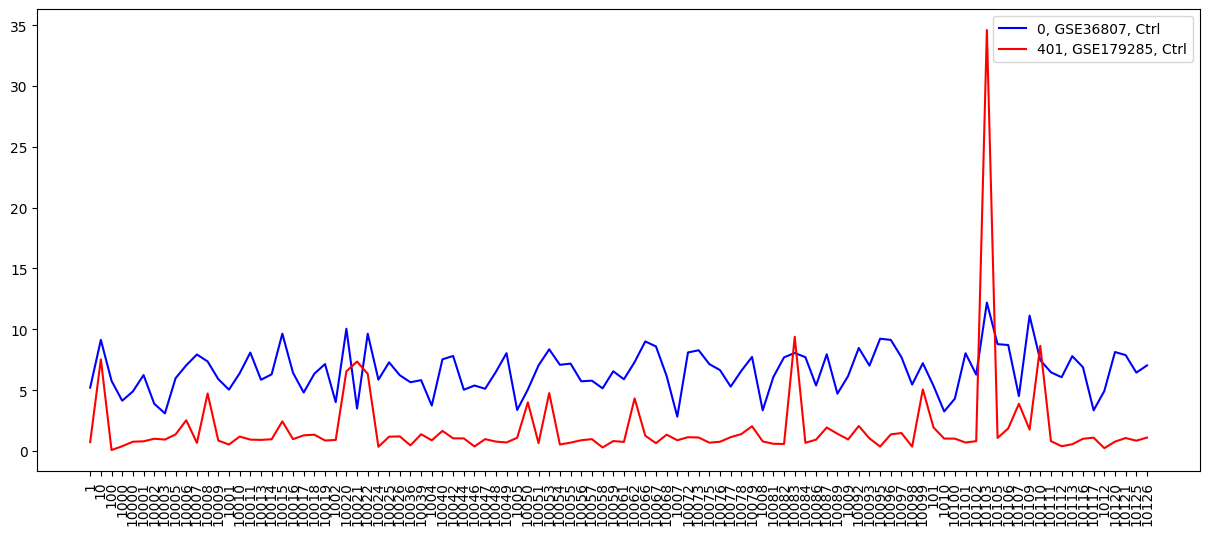

In [11]:
idx_0 = 0
idx_1 = 401
start_feature = 000
end_feature = 100
sample_0 = X.dropna(axis=1).iloc[idx_0, start_feature:end_feature]
sample_1 = X.dropna(axis=1).iloc[idx_1, start_feature:end_feature]

plt.figure(figsize=(15, 6));
plt.plot(sample_0, 'b');
plt.plot(sample_1, 'r');
plt.xticks(rotation=90);
plt.legend([f'{idx_0}, {dataset_labels.iloc[idx_0]}, {y.iloc[idx_0]}', f'{idx_1}, {dataset_labels.iloc[idx_1]}, {y.iloc[idx_1]}']);

/var/folders/04/rkl_cbwn2xd74cgn2p277ws00000gn/T/ipykernel_5681/4239693137.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(y[idx_0])
/var/folders/04/rkl_cbwn2xd74cgn2p277ws00000gn/T/ipykernel_5681/4239693137.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(y[idx_1])


Ctrl
Ctrl


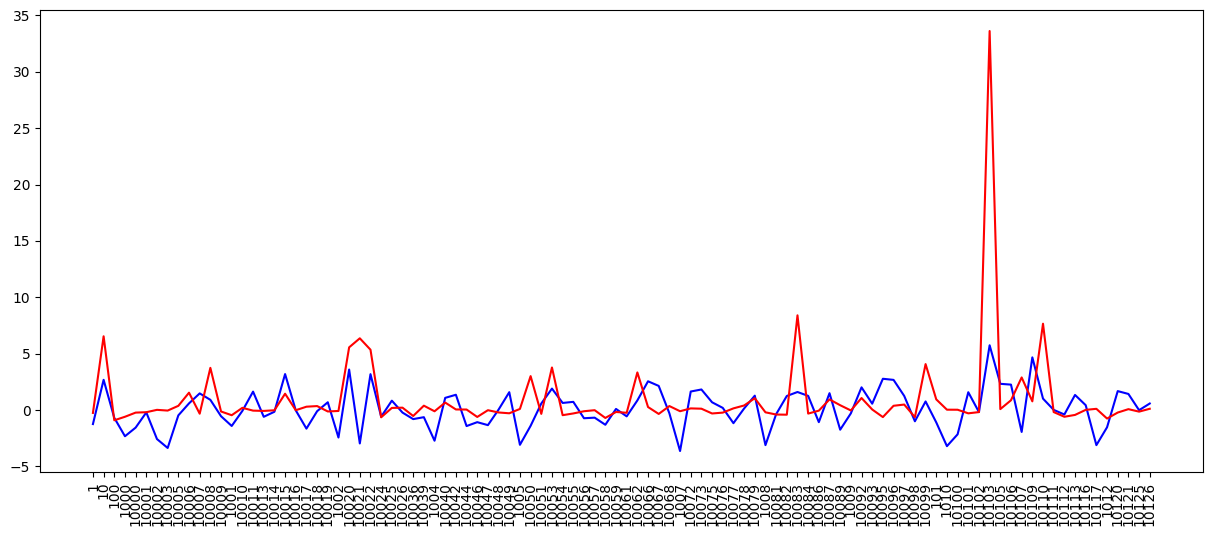

In [12]:
median_0, median_1 = sample_0.median(), sample_1.median()

plt.figure(figsize=(15, 6));
plt.plot(sample_0 - median_0, 'b');
print(y[idx_0])
plt.plot(sample_1 - median_1, 'r');
print(y[idx_1])
plt.xticks(rotation=90);

/var/folders/04/rkl_cbwn2xd74cgn2p277ws00000gn/T/ipykernel_5681/224693890.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(y[idx_0])
/var/folders/04/rkl_cbwn2xd74cgn2p277ws00000gn/T/ipykernel_5681/224693890.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(y[idx_1])


Ctrl
Ctrl


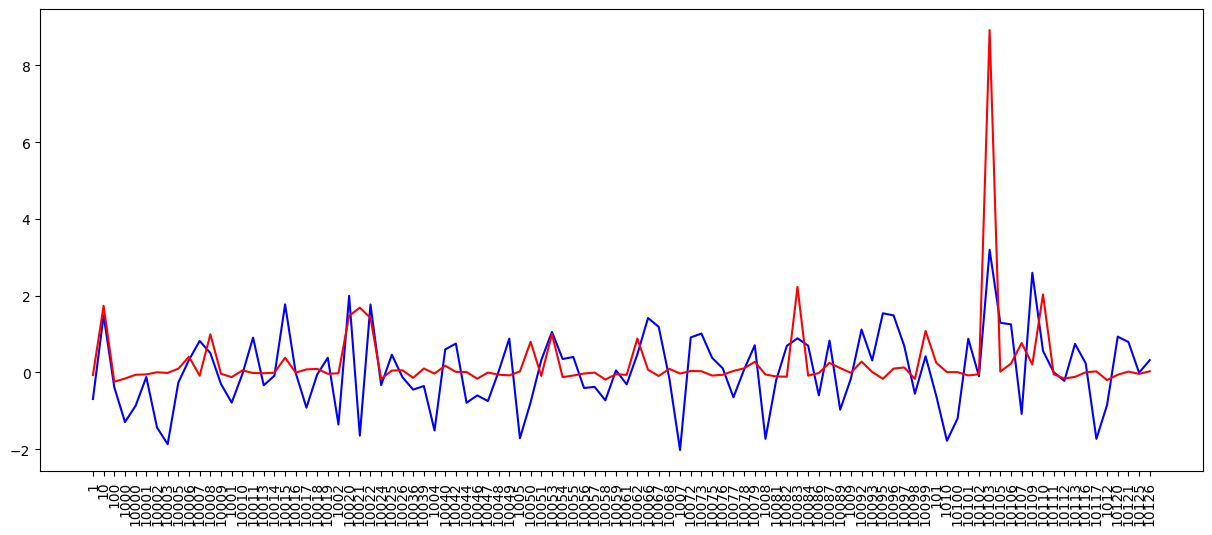

In [13]:
median_0, median_1 = sample_0.median(), sample_1.median()

sample_0_norm = (sample_0 - median_0)/(sample_0.std())
sample_1_norm = (sample_1 - median_1)/(sample_1.std())

plt.figure(figsize=(15, 6));
plt.plot(sample_0_norm, 'b');
print(y[idx_0])
plt.plot(sample_1_norm, 'r');
print(y[idx_1])
plt.xticks(rotation=90);

In [15]:
X[dataset_labels == dataset_labels.iloc[idx_0]]

ENTREZ_ID,1,10,100,1000,10000,100008586,100009676,10001,10002,10003,...,92080,9224,92379,92454,934,93949,94057,9593,9598,9981
index,,,,,,,,,,,,,,,,,,,,,
GSM901319,5.202962,9.125725,5.755603,4.122753,4.887801,3.474564,3.799347,6.234203,3.872065,3.083060,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM901320,5.334014,9.091649,6.022293,4.323495,4.636986,3.406584,3.735313,6.058270,3.902715,2.990937,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM901321,4.864362,9.070263,5.559946,4.091610,4.607338,3.484514,3.658983,6.093292,4.024982,2.950902,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM901322,5.217196,9.352801,6.034042,4.216481,4.575173,3.349321,3.625959,5.974447,4.136179,2.952561,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM901323,5.085811,9.083545,5.786575,4.225980,4.647350,3.452346,3.597027,6.240245,3.884885,3.093270,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM901324,4.977816,8.820010,5.371080,4.119786,4.568399,3.559835,3.786608,5.766589,3.884556,2.959944,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM901325,5.157439,9.144457,5.547705,4.206185,4.577896,3.365866,3.885925,6.053758,3.954717,2.918510,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM901339,6.103550,4.914917,7.595553,4.365343,5.665315,3.289793,3.608024,7.025185,3.703739,2.974687,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM901340,5.202962,9.570829,5.839560,4.061787,4.428535,3.212845,3.743795,6.323332,3.854435,2.937155,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
